# Bienvenidos al taller:
# Programación en paralelo con CUDA

### Ing. César Castrejón Peralta
### castrejonp2021@cic.ipn.mx
---
### Mini Workshop on High Performance Computing in Science and Engineering
### Noviembre 2022


# Antes de comenzar...

Para facilitar el trabajo en este taller se trabajarán los ejercicios en Colab, pero es importante recordar que no es un entorno diseñado para esto.

Es necesario instalar un paquete de GitHub y habilitarlo para que la plataforma sea capaz de compilar códigos en CUDA C/C++.

Además, se debe habilitar la ejecución en GPU, para hacerlo, debemos seguir los siguientes pasos:
1. Ir "Entorno de ejecución"
2. Cambiar tipo de entorno de ejecución
3. Usar GPU

---

In [ ]:
#@title Configuración en Colab

!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

In [ ]:
#@title Prueba básica en C

%%cu
#include <stdio.h>
int main()
{
    printf( "\t\t\t\t\t\t Welcome to\n"
            "\t\t\t\tMini Workshop on High Performance Computing\n"
            "\t\t\t\t\t in Science and Engineering");
    return 0;
}

Si el código anterior no arroja errores, podemos continuar.

Para compilar cualquier código se debe incluir el comando **%%cu** como encabezado, de lo contrario, Colab no reconocerá la sintáxis.

---

## Configuración ideal

Para instalar CUDA en una computadora es necesario contar con una GPU compatible (revisar compatibilidad en https://developer.nvidia.com/cuda-gpus) y un compilador de C. En el caso de Windows se puede seguir [este tutorial](https://www.freecodecamp.org/news/how-to-install-c-and-cpp-compiler-on-windows/) para instalarlo, o descargar algún editor como [CLion](https://www.jetbrains.com/clion/learn/)


Para ambos casos, será necesario descargar e instalar el siguiente paquete: https://developer.nvidia.com/cuda-toolkit

###Notas
- Para verificar que la instalación es correcta, se puede verificar la versión como *nvcc --version* desde la terminal.
- nvcc es el compilador al que llamaremos al trabajar con CUDA. El comando es similar a gcc o g++: *nvcc -o nombre nombra.cu*)
- Para versiones recientes de GCC, CUDA arrojará un error de compatibilidad. Si es el caso, se puede agregar la bandera *-allow-unsupported-compiler*

# Introducción

CUDA es una estensión de C/C++ para procesamiento en paralelo (en este sentido, es similar a MP y MPI, aunque estos dos son más extensos) pero enfocado en GPU.

La estructura básica se compone de dos elementos: el CPU (que se conoce como *host*), que se encarga de leer los datos de entrada, preparar la función que ejecutará la GPU (*kernel*) y de enviar y recibir los resultados; por otra parte, la GPU (*device*) sólo se encarga de procesar (en paralelo) la infomación que recibe del host, y de regresar los resultados.

Los términos *host* y *device* ya que son parte de la sintáxis de CUDA, y en algunos casos, la diferencia entre un comando u otro es la aparación o el orden de estos.

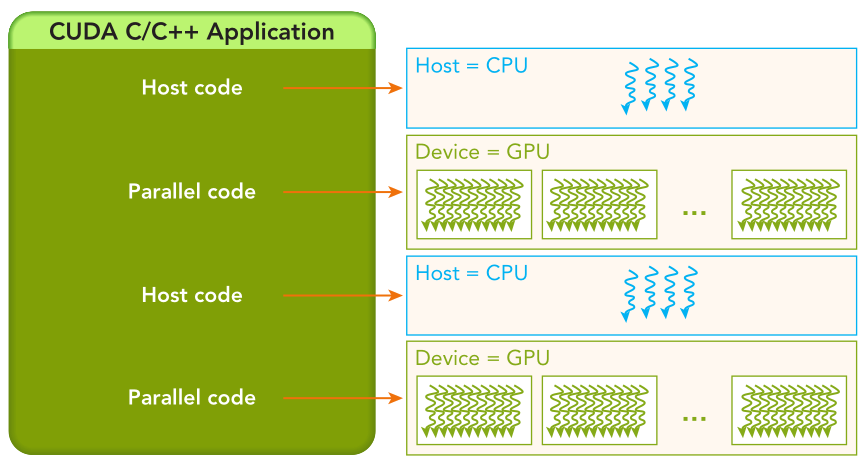

En resumen:
1. Se copia la información desde el CPU (*host*) hacia la memoria de la GPU (*device*).
2. Se llaman las funciones a realizar dentro de la GPU.
3. Se copia la información de la memoria de la GPU hacia la CPU.

---

En CUDA, la GPU se divide de la siguiente forma:
- Threads (Hilos de procesamiento)
- Blocks (Bloques de hilos)
- Grid (Grupos de bloques)

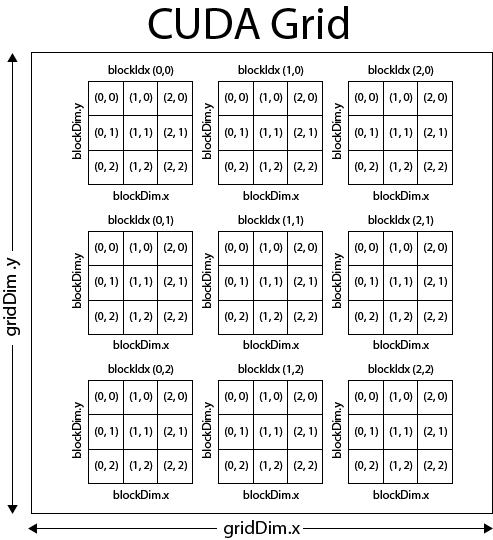

Las coordenadas de los tres niveles se pueden utilizar como índices en arreglos o como condicionales para secciones de código del kernel.

*(Se pueden generar bloques y grids hasta en 3 dimensiones)*

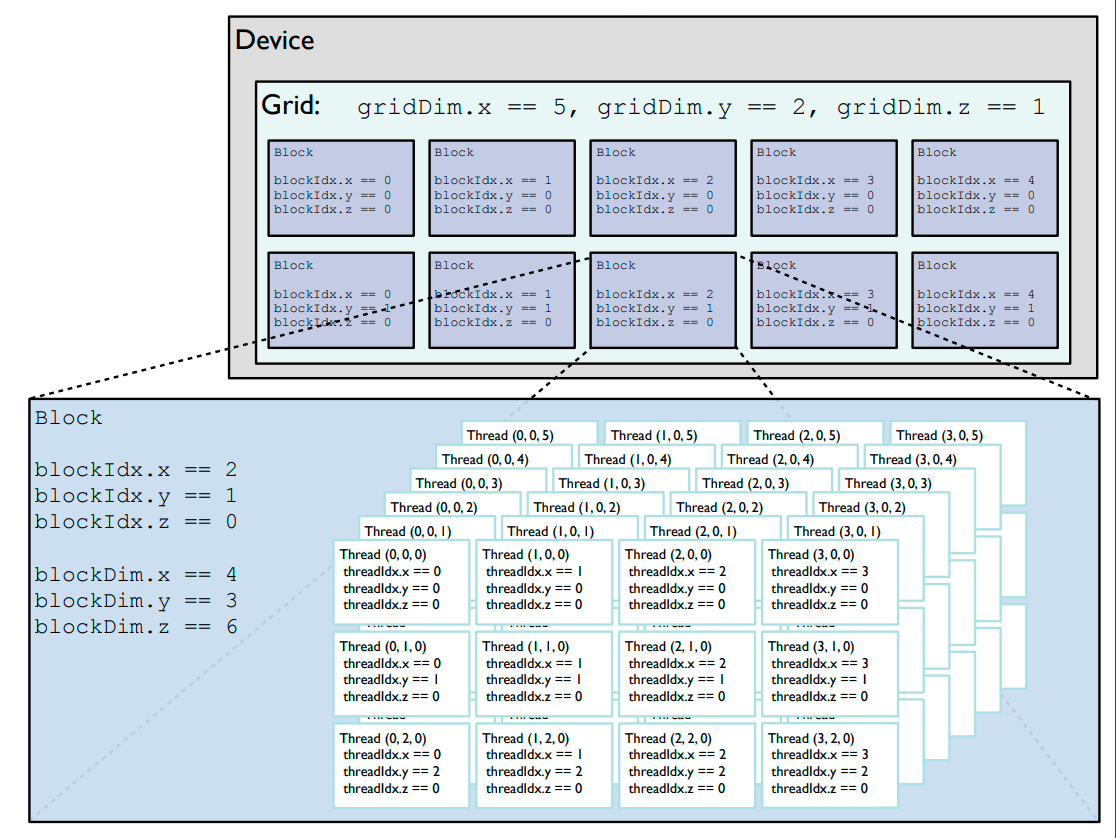

In [ ]:
#@title Hello World
%%cu

#include <stdio.h>

__global__ void helloWorld (void)
{
  int tthreadx = blockDim.x;
  int tthready = blockDim.y;
  int tthreadz = blockDim.z;
  int gridx    = gridDim.x;
  int gridy    = gridDim.y;
  int gridz    = gridDim.z;
 
  int threadx  = threadIdx.x;
  int thready  = threadIdx.y;
  int threadz  = threadIdx.z;
  int blockx   = blockIdx.x;
  int blocky   = blockIdx.y;
  int blockz   = blockIdx.z;
  
  printf("Hello World from GPU, thread (%d, %d, %d), bloque (%d, %d, %d)\n",
         threadx, thready, threadz, blockx, blocky, blockz);
   
  if (gridz == 1)
  {
    printf( "\nEl tamaño del grid es (%d, %d, %d)"
            "\nEl tamaño de cada bloque es (%d, %d, %d) (# thread(s))\n",
            gridx, gridy, gridz, tthreadx, tthready, tthreadz);
  }
}

int main(void)
{
  dim3 nBlocks(2);
  dim3 threadsPerBlock(2);
 
  printf("Hello from CPU\n");
  helloWorld <<<nBlocks, threadsPerBlock>>>();
 
  cudaDeviceSynchronize();
  cudaDeviceReset();
 
  return 0;
}

- *\_\_global__* indica al compilador que la función se debe ejecutar en la GPU, es decir, es el *kernel*.
- *nombre_funcion <<<numero_bloques, threads_p_bloque>>> (param_entrada)* es la estructura básica para comenzar la ejecución del kernel.
<ul>
- *numero_bloques* Se pueden tener máximo $65535$ grids, divididos en 3 dimensiones. Cada dimensión puede ser de máximo $65535$.
- *threads_p_bloque* Se pueden tener máximo $1024$ threads, divididos en 3 dimensiones. EL tamaño máximo de cada dimensión es $1024$ en x, $1024$ en y, $64$ en z
</ul>
- *cudaDeviceSynchronize()* CUDA funciona de forma asincrona, es decir, cada thread devuelve el resultado de su operación cuando termina, sin esperar al resto de resultados. Este comando espera a que terminen todos los procesos de la llamada al kernel. (Más adelante se verá un comando similar que funciona dentro de la función)
- *cudaDeviceReset()* elimina (y reinicia) **toda** la información asociada al kernel. Existe un comando similar a *free()*, que sólo libera el espacio en memoria de cada variable. **Similar a la programación clásica en C/C++, es importante siempre liberar la memoria**.
- Los comandos con el término *Idx.#* regresan el nombre (o clave) del elemento actual, el término *Dim.#* regresan la cantidad en el eje indicado (esto es válido para todos los módulos de programación en paralelo, como OpenMP, MPI).

In [ ]:
#@title Getting information
%%cu
#include <stdio.h>

int main()
{
  cudaDeviceProp prop;
  int count;

  cudaGetDeviceCount(&count);

  for (int i = 0; i < count; i++)
  {
    cudaGetDeviceProperties(&prop, i);

    printf( "\n--------- General Information for device %d ---------\n"
            "\tName: %s\n"
            "\tCompute capability: %d.%d\n"
            "\tClock rate: %d KHz\n\n", 
            i, prop.name, prop.major, prop.minor, prop.clockRate);

    printf( "\tTotal global memory:   %d\n"
            "\tTotal constant memory: %d\n\n",
            prop.totalGlobalMem, prop.totalConstMem);
    
    printf( "\tMaximum threads per block: %d\n"
            "\tMaximum thread dimensions: (%d, %d, %d)\n"
            "\tMaximum grid dimensions:   (%d, %d, %d)\n\n",
            prop.maxThreadsPerBlock,
            prop.maxThreadsDim[0], prop.maxThreadsDim[1], prop.maxThreadsDim[2],
            prop.maxGridSize[0], prop.maxGridSize[1], prop.maxGridSize[2]);
  }

  return 0;
}

El resto de las propiedades se pueden consultar en https://developer.download.nvidia.com/compute/DevZone/docs/html/C/doc/html/group__CUDART__DEVICE_g5aa4f47938af8276f08074d09b7d520c.html

Aunque la documentación es de una versión vieja, la estructura es igual a la versión actual.

In [ ]:
#@title Multiplicación de vectores
%%cu

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <unistd.h>


#define N 1000
#define THREADS_BLOCK 10

__global__ void vecXvec(int *A, int *B, int *C)
{
  int tid = threadIdx.x + (blockIdx.x * blockDim.x);
  
  while (tid < N)
  {
    C[tid] = A[tid] + B[tid];
    tid += blockDim.x * gridDim.x;
  }
}

int main(void)
{
  // Varibles to measure execution time
  struct timeval ts0, ts1;
  double ts;
  cudaEvent_t tc0, tc1;
  float tc;
  cudaEventCreate(&tc0);
  cudaEventCreate(&tc1);

  // Create host variables and allocate memory
  int *A, *B, *C, *res_S;
  A = (int *) malloc(N * sizeof(int));
  B = (int *) malloc(N * sizeof(int));
  C = (int *) malloc(N * sizeof(int));
  res_S = (int *) malloc(N * sizeof(int));

  // CReate device variables
  int *dev_a, *dev_b, *dev_c;

  // Stablish kernel configuration parameters
  int nb = (int) N/THREADS_BLOCK;
  dim3 nBlocks(nb); // First parameter
  dim3 tBlock(THREADS_BLOCK); // Second parameter
 
  // Fill the vectors
  for (int i = 0; i < N; i++)
  {
    A[i] = (rand() % 10) + 1;
    B[i] = (rand() % 15) + 1;
  }

  // Allocate the memory on the host
  cudaMalloc( (void**) &dev_a, N * sizeof(int) );
  cudaMalloc( (void**) &dev_b, N * sizeof(int) );
  cudaMalloc( (void**) &dev_c, N * sizeof(int) );

  // Copy arrays to GPU
  cudaMemcpy( dev_a, A, N * sizeof(int), cudaMemcpyHostToDevice );
  cudaMemcpy( dev_b, B, N * sizeof(int), cudaMemcpyHostToDevice );

  cudaEventRecord( tc0, 0 );

  // Run the kernel function
  vecXvec <<<nBlocks, tBlock>>>(dev_a, dev_b, dev_c);
 
  cudaEventRecord( tc1, 0 );
  cudaEventSynchronize( tc1 );
  cudaEventElapsedTime( &tc, tc0, tc1 );
  cudaEventDestroy( tc0 );
  cudaEventDestroy( tc1 );

  // Copy the result from device to host
  cudaMemcpy( C, dev_c, N * sizeof(int), cudaMemcpyDeviceToHost );

  gettimeofday(&ts0, 0);
  for (int i = 0; i < N; i++)
  {
    res_S[i] = A[i] + B[i];
  }
  gettimeofday(&ts1, 0);   
  ts = (ts1.tv_sec - ts0.tv_sec) + (ts1.tv_usec - ts0.tv_usec) / 1e3;

  // Print the result
  //for (int i = 0; i < N; i++)
  //{
  //  printf("\t%d * %d = %d\n", A[i], B[i], C[i]);
  //}

  printf( "\n\tCUDA Time = %1.3f ms\n"
          "\tSequential Time = %1.3f ms\n\n", tc, ts);

  cudaFree(dev_a);
  cudaFree(dev_b);
  cudaFree(dev_c);
  free(A);
  free(B);
  free(C);
 
  return 0;
}

- *cudaMalloc( (void**) &nombre_var, tamaño_var)* Crea el espacio en la memoria de la GPU, con el nombre *nombre_var* (**se deben usar apuntadores**), asignandole el tamaño *tamaño_var*. Generalmente se usa *dev_##* para nombrar a la variable, y la función *sizeof()* para asignar el tipo de dato (similar a *malloc* en C).
- Para medir el tiempo de ejecución en CUDA, se debe usar *cudaEvent_t* y *cudaEventRecord()*
- *dim3* es una estructura propia de CUDA, que permite indicar el tamaño de las 3 dimensiones de grid y bloques.
- *cudaFree()* libera la memoria de la variable que se indique.
- *tid = threadIdx.x + blockIdx.x * blockDim.x* y *tid += blockDim.x * gridDim.x* se utilizan como índices para la variable *C*. Usar las propiedades *Idx* y *Dim* de esta forma también es común openMP y MPI.

### Nota
Aunque es posible añadir más threads de los necesarios (por ejemplo, tener un proceso que se sólo repite 10 veces, pero indicar 20 threads), esto no es recomendable ya que, aunque en configuraciones pequeñas no es perceptible, hacerlo *nos cuesta tiempo*. Al final del notebook se incluyen algunos puntos sobre esto.

## *Race condition*
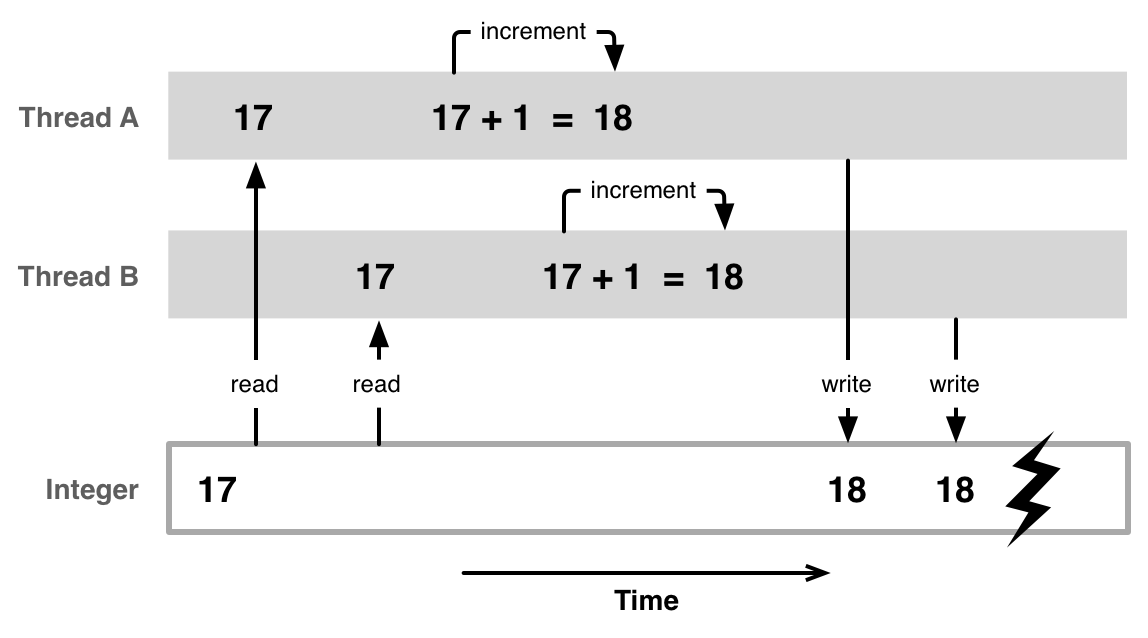

# Operaciones con matrices

In [ ]:
#@title Producto punto
%%cu

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <unistd.h>

#define N 16384
#define THREADS_BLOCK 512

__global__ void dot_pr(int *a, int *b, int *r)
{
    __shared__ int temp[THREADS_BLOCK];
    int tid = threadIdx.x + (blockIdx.x * blockDim.x);
    temp[threadIdx.x] = a[tid] * b[tid];

    __syncthreads();

    if (threadIdx.x == 0)
    {
        int sum = 0;
        for (int i = 0; i < THREADS_BLOCK; i++)
        {
            sum += temp[i];
        }
        atomicAdd(r, sum);
    }
}

int main()
{
    // Varibles to measure execution time
    struct timeval ts0, ts1;
    double ts;
    cudaEvent_t tc0, tc1;
    float tc;
    cudaEventCreate(&tc0);
    cudaEventCreate(&tc1);

    // Create host variables and allocate memory
    int *a, *b, *r, res_S;
    a = (int*) malloc( N * sizeof(int) );
    b = (int*) malloc( N * sizeof(int) );
    r = (int*) malloc( sizeof(int) );

    // Create device variables
    int *dev_a, *dev_b, *dev_r;

    // Stablish kernel configuration parameters
    int nb = (int) N/THREADS_BLOCK;
    dim3 nBlocks(nb); // First parameter
    dim3 tBlock(THREADS_BLOCK); // Second parameter
    
    // Fill the vectors
    for (int i = 0; i < N; i++)
    {
        a[i] = (rand() % 10) + 1;
        b[i] = (rand() % 10) + 1; 
    }

    // Allocate the memory on the host
    cudaMalloc( (void**) &dev_a, N * sizeof(int) );
    cudaMalloc( (void**) &dev_b, N * sizeof(int) );
    cudaMalloc( (void**) &dev_r, sizeof(int) );
    
    // Copy arrays to the host
    cudaMemcpy( dev_a, a, N * sizeof(int), cudaMemcpyHostToDevice );
    cudaMemcpy( dev_b, b, N * sizeof(int), cudaMemcpyHostToDevice );
    
    cudaEventRecord( tc0, 0 );
 
    // Run the kernel function
    dot_pr<<< nBlocks, tBlock >>> (dev_a, dev_b, dev_r);
 
    cudaEventRecord( tc1, 0 );
    cudaEventSynchronize( tc1 );
    cudaEventElapsedTime( &tc, tc0, tc1 );
    cudaEventDestroy( tc0 );
    cudaEventDestroy( tc1 );
    
    // Copy the result from device to host
    cudaMemcpy( r, dev_r, sizeof(int), cudaMemcpyDeviceToHost );

    gettimeofday(&ts0, 0);
    res_S = 0;
    for (int i = 0; i < N; i++)
    {
        res_S += a[i] * b[i];
    }
    gettimeofday(&ts1, 0);   
    ts = (ts1.tv_sec - ts0.tv_sec) + (ts1.tv_usec - ts0.tv_usec) / 1e3;

    printf( "\n\tCUDA Time = %1.3f ms\n"
            "\tSequential Time = %1.3f ms\n\n", tc, ts);
    
    printf( "\t\t  CUDA \t      Sequential\n"
            "\tResult = %d \t%d\n", *r, res_S);

    cudaFree(dev_a);
    cudaFree(dev_b);
    cudaFree(dev_r);
    free(a);
    free(b);
    free(r);

    return 0;
 }

- *\_\_shared__* permite que todos los threads puedan accesar a la(s) variables(s). Se debe tener cuidado al usar este tipo de variables y los índices, ya que sin darnos cuenta, podemos modificar erróneamente la información. Se puede consultar más información [aquí](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#variable-memory-space-specifiers)
- *__syncthreads()* espera a que todos los threads terminen el proceso actual. Es importante usarlo cuando se llena una variable que se usará en procesos posteriores dentro del kernel. Esto previene problemas como la *race condition*.

In [ ]:
#@title Multiplicación de matrices
%%cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <sys/time.h>
#include <unistd.h>

#define ROW 10
#define COL 10
#define SHV 10
#define N 10

__global__ void mat2mat(double *dev_a, double *dev_b, double *dev_r) 
{
    __shared__ double row_a[ROW][SHV];
    __shared__ double col_b[SHV][COL];
    
    int row = threadIdx.x + (blockIdx.x * blockDim.x);
    int col = threadIdx.y + (blockIdx.y * blockDim.y);
    double res_tmp = 0.0;
    int idx, idy;

    idx = threadIdx.y + (threadIdx.x * SHV);
    idy = threadIdx.x + (threadIdx.y * COL);

    if (idx < ROW * SHV && threadIdx.y < SHV)
    {
        row_a[threadIdx.x][threadIdx.y] = dev_a[idx];
    }
    if (idy < SHV * COL && threadIdx.y < SHV)
    {
        col_b[threadIdx.y][threadIdx.x] = dev_b[idy];
    }
    __syncthreads();

    for (int k = 0; k < SHV; k++)
    {
        res_tmp += row_a[threadIdx.y][k] * col_b[k][threadIdx.x];
    }
    __syncthreads();

    if (row < ROW && col < COL)
    {
        dev_r[col + SHV * row] = res_tmp;    
    }
}


int main(int argc, char const *argv[])
{
    // Varibles to measure execution time
    cudaEvent_t tc0, tc1;
    float tc;
    cudaEventCreate(&tc0);
    cudaEventCreate(&tc1);

    // Create host variables and allocate memory    
    // The three matrices are converted to 1D arrays
    double *MA, *MB, *MR;
    MA = (double*) malloc(ROW * SHV * sizeof(double));
    MB = (double*) malloc(SHV * COL * sizeof(double));
    MR = (double*) malloc(ROW * COL * sizeof(double));

    // Create device variables
    double *dev_a, *dev_b, *dev_r;

    // Stablish GPU parameters
    dim3 nBlocks(1, 1);
    dim3 threadsPerBlock(N, N);
    
    for (int i = 0; i < ROW * SHV; i++)
    {
        MA[i] = 1*i;
    }
    for (int i = 0; i < SHV * COL; i++)
    {
        MB[i] = 2*i;
    }
    
    // Allocate the memory on the host
    cudaMalloc( (void**) &dev_a, ROW * SHV * sizeof(double) );
    cudaMalloc( (void**) &dev_b, SHV * COL * sizeof(double) );
    cudaMalloc( (void**) &dev_r, ROW * COL * sizeof(double) );

    // Copy arrays to the host
    cudaMemcpy( dev_a, MA, ROW * SHV * sizeof(double), cudaMemcpyHostToDevice );
    cudaMemcpy( dev_b, MB, SHV * COL * sizeof(double), cudaMemcpyHostToDevice );
    
    cudaEventRecord( tc0, 0 );

    // Run the kernel function
    mat2mat<<<nBlocks, threadsPerBlock>>> (dev_a, dev_b, dev_r);
    
    cudaEventRecord( tc1, 0 );
    cudaEventSynchronize( tc1 );
    cudaEventElapsedTime( &tc, tc0, tc1 );
    cudaEventDestroy( tc0 );
    cudaEventDestroy( tc1 );

    // Copy the result from device to host
    cudaMemcpy( MR, dev_r, ROW * COL * sizeof(double), cudaMemcpyDeviceToHost );
    
    // Print the result
    /*
    printf("\n\n");
    for (int i = 0; i < ROW; i++)
    {
        for (int k = 0; k < SHV; k++)
        {
            printf("\t%2.0f", MA[k+i*SHV]);
        }
        printf("\n");
    }
    printf("\n");
    for (int i = 0; i < SHV; i++)
    {
        for (int k = 0; k < COL; k++)
        {
            printf("\t%2.0f", MB[k+i*COL]);
        }
        printf("\n");
    }
    */
    printf("\n");
    for (int i = 0; i < ROW; i++)
    {
        for (int k = 0; k < COL; k++)
        {
            printf("\t%2.0f", MR[i+COL*k]);
        }
        printf("\n");
    }

    printf( "\n\tCUDA Time = %1.3f ms\n", tc);

    cudaFree(dev_a);
    cudaFree(dev_b);
    cudaFree(dev_r);
    free(MA);
    free(MB);
    free(MR);
    return 0;
}

Una forma sencilla de trabajar con matrices es convertirlas a arreglos 1D y usar los índices de los threads, bloques y grids como indices de las matrices dentro del kernel.

# Ejemplo

In [ ]:
#@title Cálculo de distancia mínima (versión básica)
%%cu

#include <stdio.h>
#include <math.h>
#include <sys/time.h>
#include <unistd.h>

#define N 10000

__global__ void distance ( int* ivec, int* thxvec,
                  double* X,  double* Y, double* dev_res )
{
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int it, thxt;
    
    double mind = 10000.0;
    double dist;
    
    if (tid < N)
    {
        for (int i = 0; i < N; i++)
        {
            if (tid != i)
            {
                dist = sqrt(pow((X[tid]-X[i]), 2) + pow((Y[tid]-Y[i]), 2));
                if (dist < mind)
                {
                    mind = dist;
                    thxt = tid;
                    it = i;
                }
            }
        }
        dev_res[tid] = mind;
        thxvec[tid] = thxt;
        ivec[tid] = it;
    }
   
}

int main ()
{
    // Varibles to measure execution time
    struct timeval tc0, tc1;
    double tc;

    // Create host variables and allocate memory
    double *X, *Y, *resultado;
    double min_t;
    int *i_res, *thx_res;
    int p1_t, p2_t;
    X   = (double*) malloc( N * sizeof(double) );
    Y   = (double*) malloc( N * sizeof(double) );
    resultado = (double*) malloc( N * sizeof(double) );
    i_res     = (int*) malloc( N * sizeof(int) );
    thx_res   = (int*) malloc( N * sizeof(int) );
    

    // Create device variables
    double *dev_x,  *dev_y, *dev_r;
    int *dev_i, *dev_t;

    // Stablish kernel configuration parameters
    dim3 nBlocks(100); // First parameter
    dim3 tBlock(100); // Second parameter
    
    // Fill the vectors
    for(int k = 0; k < N; k++)
    {
        X[k] = (k%2==0) ? k*1.8:(9.510+k)/3;
        Y[k] = (k%2==0) ? k*3.8:(k+k*0.3)/3;
    }
    
    gettimeofday(&tc0, 0);

    // Allocate the memory on the host
    cudaMalloc( (void**) &dev_x,  N * sizeof(double) );
    cudaMalloc( (void**) &dev_y,  N * sizeof(double) );
    cudaMalloc( (void**) &dev_r,  N * sizeof(double) );
    cudaMalloc( (void**) &dev_i,  N * sizeof(int) );
    cudaMalloc( (void**) &dev_t,  N * sizeof(int) );
    
    // Copy arrays to the host
    cudaMemcpy( dev_x, X, N * sizeof(double), cudaMemcpyHostToDevice );
    cudaMemcpy( dev_y, Y, N * sizeof(double), cudaMemcpyHostToDevice );
    
    // Run the kernel function
    distance<<<nBlocks, tBlock>>> ( dev_i, dev_t, dev_x, dev_y, dev_r );

    // Copy the result from device to host
    cudaMemcpy( resultado, dev_r, N * sizeof(double), cudaMemcpyDeviceToHost );
    cudaMemcpy( thx_res,   dev_t, N * sizeof(int), cudaMemcpyDeviceToHost );
    cudaMemcpy( i_res,     dev_i, N * sizeof(int), cudaMemcpyDeviceToHost );
    cudaDeviceSynchronize();
    
    gettimeofday(&tc1, 0);
    tc = (tc1.tv_sec - tc0.tv_sec) + (tc1.tv_usec - tc0.tv_usec) / 1e3;

    min_t = resultado[0];
    for (int i = 1; i < N; i++)
    {
        min_t = (resultado[i] < min_t) ? resultado[i]:min_t;
        p1_t = thx_res[i];
        p2_t = i_res[i];
    }

    printf( "\n\tCUDA Time = %1.3f ms\n", tc);

    
    printf( "\nThe minimum distance is: %6.2f\n"
            "Between the points\n"
            "p1(%6.2f, %6.2f) -- p2(%6.2f, %6.2f)\n\n",
            min_t, X[p1_t], Y[p1_t], X[p2_t], Y[p2_t]);
    
    cudaFree(dev_x);
    cudaFree(dev_y);
    cudaFree(dev_r);

    return 0;
}

In [ ]:
#@title Cálculo de distancia mínima (versión avanzada)
%%cu

#include <math.h>
#include <random>
#include <cstdio>
#include <iostream>

#define nsamples 100
 
using namespace std;
 
__global__ void maxi(int* a, int* b, int n){
    int block = 256 * blockIdx.x;
    int max = 0;
 
    for (int i = block; i < min(256 + block, n); i++) {
 
        if (max < a[i]) {
            max = a[i];
        }
    }
    b[blockIdx.x] = max;
}
 
int main(){
 
    int n;
    n = 3 >> 2;
    int a[n];
 
    for (int i = 0; i < n; i++) {
        a[i] = rand() % n;
        cout << a[i] << "\t";
    }
 
    cudaEvent_t start, end;
    int *ad, *bd;
    int size = n * sizeof(int);
    cudaMalloc(&ad, size);
    cudaMemcpy(ad, a, size, cudaMemcpyHostToDevice);
    int grids = ceil(n * 1.0f / 256.0f);
    cudaMalloc(&bd, grids * sizeof(int));
 
    dim3 grid(grids, 1);
    dim3 block(1, 1);
 
    cudaEventCreate(&start);
    cudaEventCreate(&end);
    cudaEventRecord(start);
 
    while (n > 1) {
        maxi<<<grids, block >>>(ad, bd, n);
        n = ceil(n * 1.0f / 256.0f);
        cudaMemcpy(ad, bd, n * sizeof(int), cudaMemcpyDeviceToDevice);
    }
 
    cudaEventRecord(end);
    cudaEventSynchronize(end);
 
    float time = 0;
    cudaEventElapsedTime(&time, start, end);
 
    int ans[2];
    cudaMemcpy(ans, ad, 4, cudaMemcpyDeviceToHost);
 
    cout << "The maximum element is : " << ans[0] << endl;
 
    cout << "The time required : ";
    cout << time << endl;
}

# Consideraciones

1. En cualquier caso de programación en paralelo (CUDA, openMP, MPI, etc), internamente se requiere de tiempo de preparación de los recursos que se van a emplear.
2. El manejo de la información necesaria genera latencia, es decir, más tiempo de ejecución.
3. En algunos casos, pasar de una solución secuencial a una paralela no es sencillo.
4. En algunos casos, sobre todo en problemas con variables pequeñas, es posible encontrarnos con tiempos de ejecución iguales o más grandes que los de soluciones secuenciales.

Con lo anterior, es importante analizar si el problema que se quiere resolver realmente se beneficia del paralelismo (considerando los puntos anteriores). En algunos casos, el beneficio en tiempo de ejecución es mínimo considerando el tiempo y los requisitos de la programación en paralelo.